# DCA Strategy Comparison for High and Low Beta ETFs

This notebook compares four Dollar Cost Averaging (DCA) strategies across a selection of High Beta and Low Beta ETFs.

## Strategies
1. **Naive DCA**: Invest a fixed amount ($C$) at regular intervals.
2. **Enhanced DCA**: Adjust investment based on price movement. Invest $C - \delta$ if price is up, $C + \delta$ if price is down.
3. **Value-based DCA (No Sell)**: Aim for a target portfolio value that grows linearly. Invest difference between target and current value, but never sell (min investment 0).
4. **Value-based DCA (With Sell)**: Aim for a target portfolio value. Buy or sell to maintain the target value path.

## ETFs
- **High Beta**: TQQQ, QQQ, SPY (actually it is neutral)
- **Low Beta**: Covered call ETFs - JEPQ, JEPI

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Configuration
high_beta_tickers = ['TQQQ', 'QQQ', 'SPY']
low_beta_tickers = ['JEPQ', 'JEPI']
tickers = high_beta_tickers + low_beta_tickers

start_date = '2021-01-01'
end_date = '2023-12-31'
interval = '1mo'  # Monthly DCA

# DCA Parameters
base_investment = 1000.0  # $1000 per month
delta = 200.0             # For Enhanced DCA ( +/- $200)
target_growth = 1000.0    # For Value-based (Target portfolio value increases by $1000/mo)


In [25]:
# Fetch Data
# Note: Recent yfinance versions auto-adjust data by default, so 'Close' is adjusted close.
data = yf.download(tickers, start=start_date, end=end_date, interval=interval)['Close']
data = data.dropna()
data.head()


/var/folders/0p/3mbt9gm91jn236g6qf0mkz380000gn/T/ipykernel_22826/947294597.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date, interval=interval)['Close']
[*********************100%***********************]  5 of 5 completed


Ticker,JEPI,JEPQ,QQQ,SPY,TQQQ
Date,,,,,
2022-05-01,41.762695,32.777630,300.976501,391.812012,15.809603
2022-06-01,40.199604,30.493299,273.639771,357.956696,11.480498
2022-07-01,42.008308,33.004597,308.578339,392.608704,15.957890
2022-08-01,40.878841,31.282957,292.741547,376.589508,13.303029
2022-09-01,38.227127,28.412931,261.429840,340.377106,9.241798


In [26]:
def run_strategies(price_series, base_inv, delta, target_growth):
    dates = price_series.index
    n = len(dates)
    
    results = {
        'Naive': {'units': 0.0, 'cash_spent': 0.0, 'portfolio_value': [], 'invested': []},
        'Enhanced': {'units': 0.0, 'cash_spent': 0.0, 'portfolio_value': [], 'invested': []},
        'Value_NoSell': {'units': 0.0, 'cash_spent': 0.0, 'portfolio_value': [], 'invested': []},
        'Value_Sell': {'units': 0.0, 'cash_spent': 0.0, 'portfolio_value': [], 'invested': []}
    }
    
    # Value targets
    target_values = [target_growth * (i + 1) for i in range(n)]
    
    for i in range(n):
        price = price_series.iloc[i]
        prev_price = price_series.iloc[i-1] if i > 0 else price
        
        # --- 1. Naive DCA ---
        inv_naive = base_inv
        units_bought = inv_naive / price
        results['Naive']['units'] += units_bought
        results['Naive']['cash_spent'] += inv_naive
        results['Naive']['portfolio_value'].append(results['Naive']['units'] * price)
        results['Naive']['invested'].append(results['Naive']['cash_spent'])

        # --- 2. Enhanced DCA ---
        if price > prev_price:
            inv_enhanced = base_inv - delta
        elif price < prev_price:
            inv_enhanced = base_inv + delta
        else:
            inv_enhanced = base_inv
            
        # Ensure non-negative investment if delta is large
        inv_enhanced = max(0, inv_enhanced)
        
        units_bought = inv_enhanced / price
        results['Enhanced']['units'] += units_bought
        results['Enhanced']['cash_spent'] += inv_enhanced
        results['Enhanced']['portfolio_value'].append(results['Enhanced']['units'] * price)
        results['Enhanced']['invested'].append(results['Enhanced']['cash_spent'])

        # --- 3. Value Based (No Sell) ---
        current_val = results['Value_NoSell']['units'] * price
        target_val = target_values[i]
        required_inv = target_val - current_val
        
        real_inv = max(0, required_inv)
        units_bought = real_inv / price
        
        results['Value_NoSell']['units'] += units_bought
        results['Value_NoSell']['cash_spent'] += real_inv
        results['Value_NoSell']['portfolio_value'].append(results['Value_NoSell']['units'] * price)
        results['Value_NoSell']['invested'].append(results['Value_NoSell']['cash_spent'])

        # --- 4. Value Based (With Sell) ---
        current_val = results['Value_Sell']['units'] * price
        target_val = target_values[i]
        required_inv = target_val - current_val
        
        # Positive required_inv means buy, negative means sell
        units_bought = required_inv / price
        
        results['Value_Sell']['units'] += units_bought
        results['Value_Sell']['cash_spent'] += required_inv # Net cash flow
        results['Value_Sell']['portfolio_value'].append(results['Value_Sell']['units'] * price)
        results['Value_Sell']['invested'].append(results['Value_Sell']['cash_spent'])
        
    return results


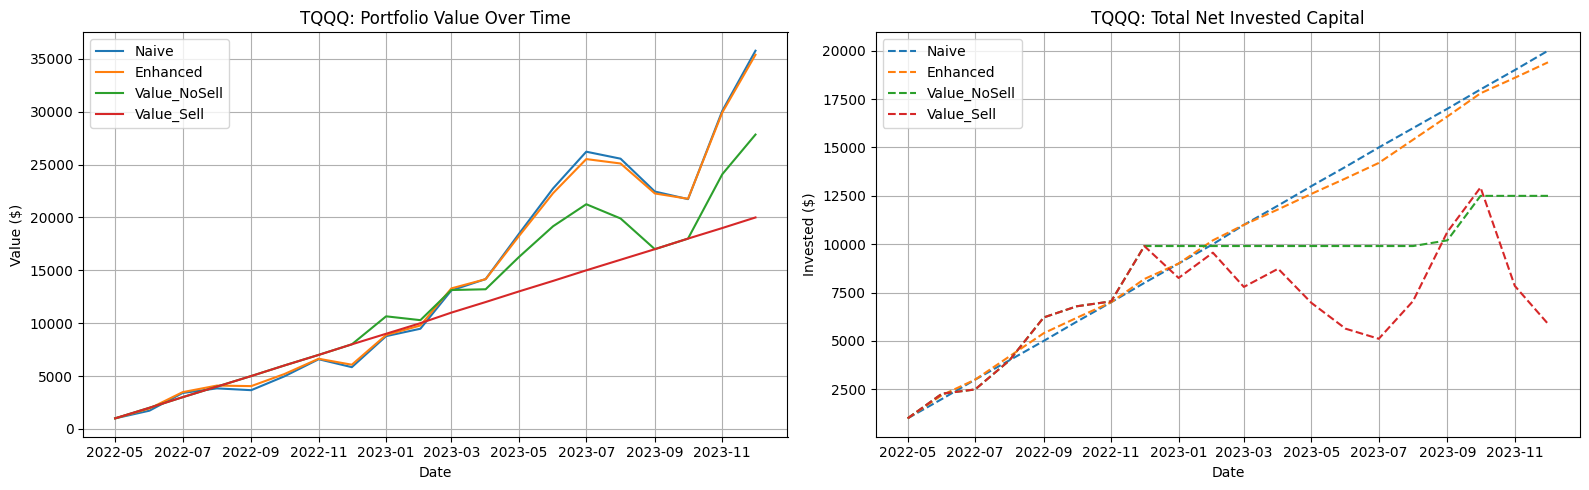

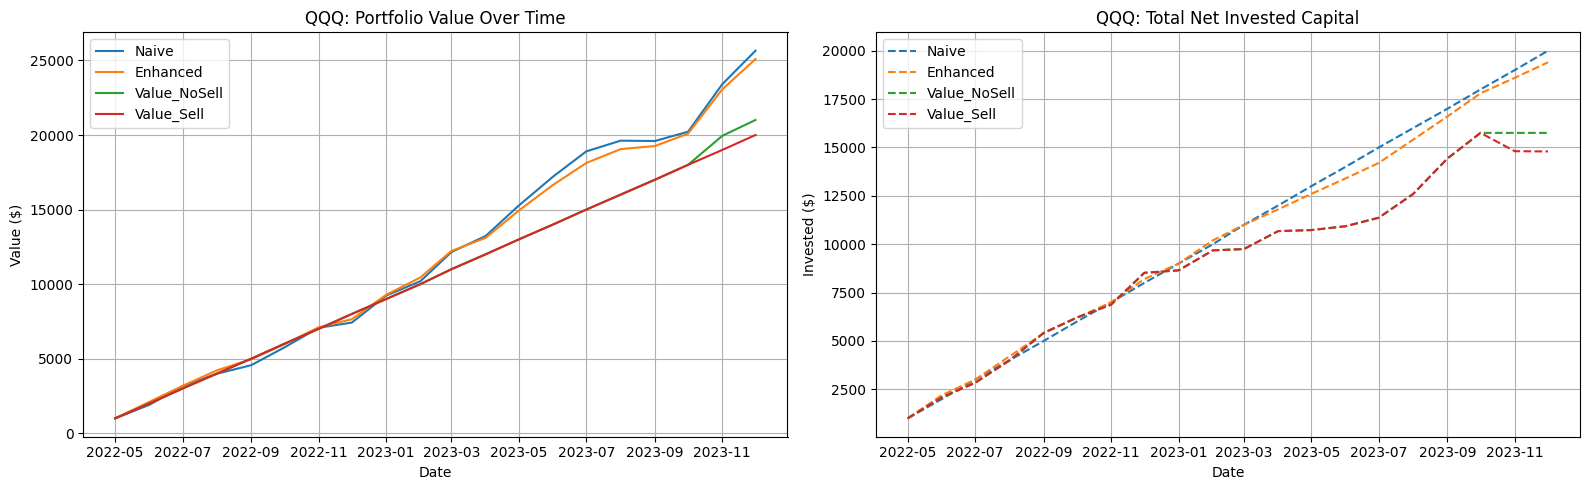

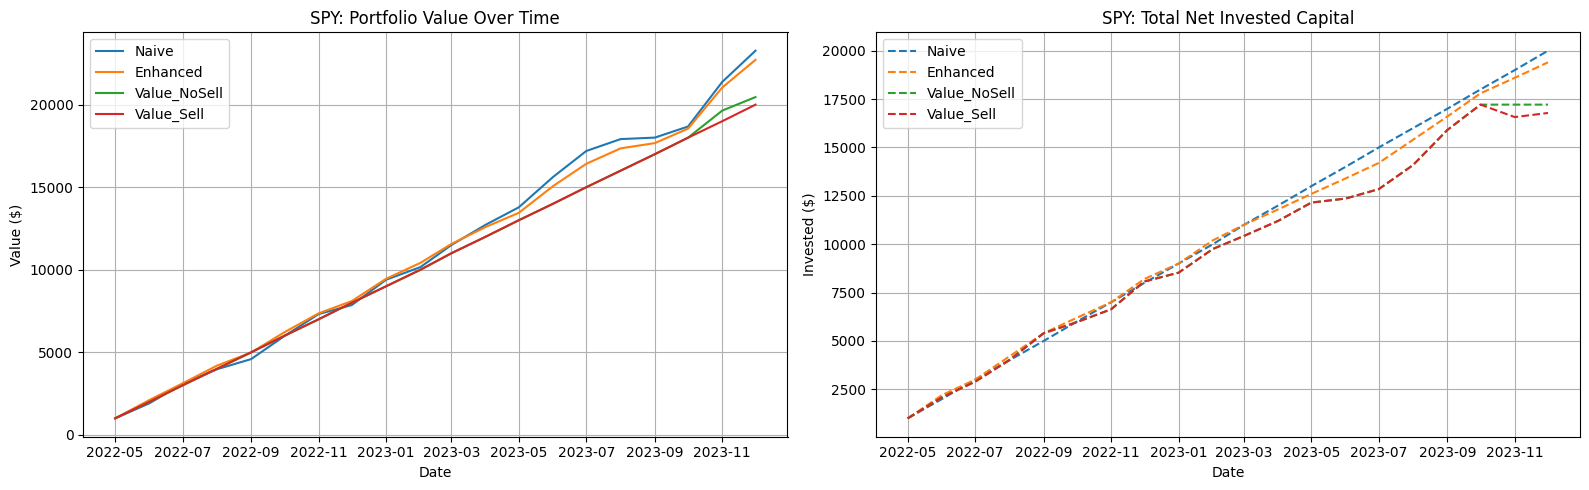

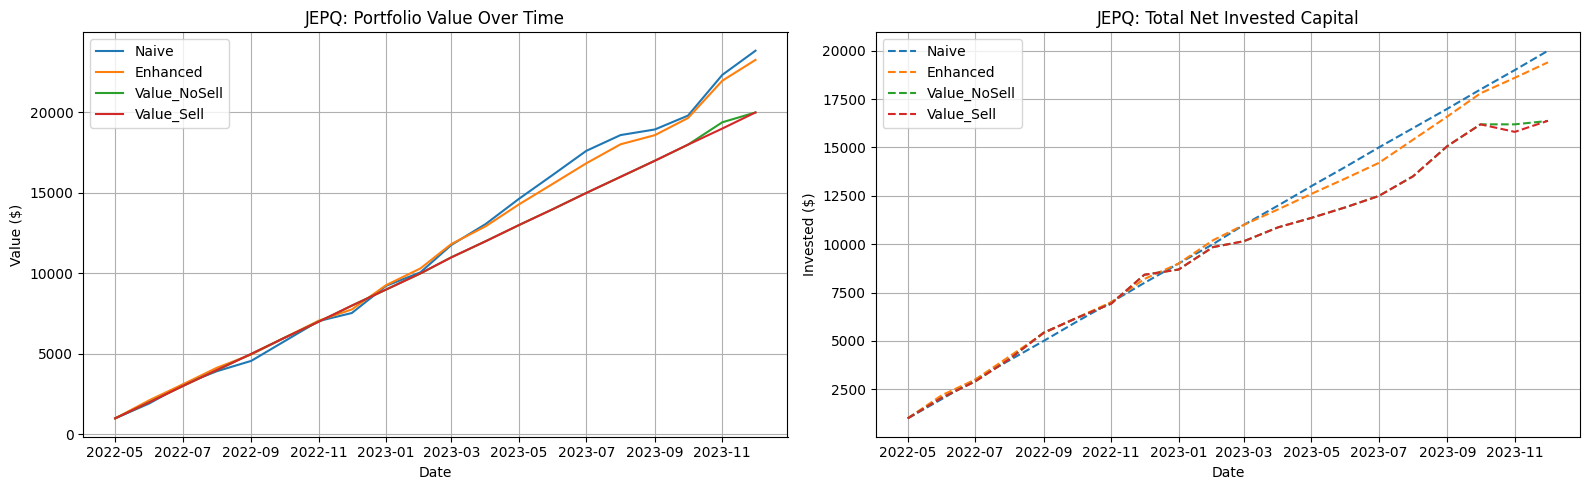

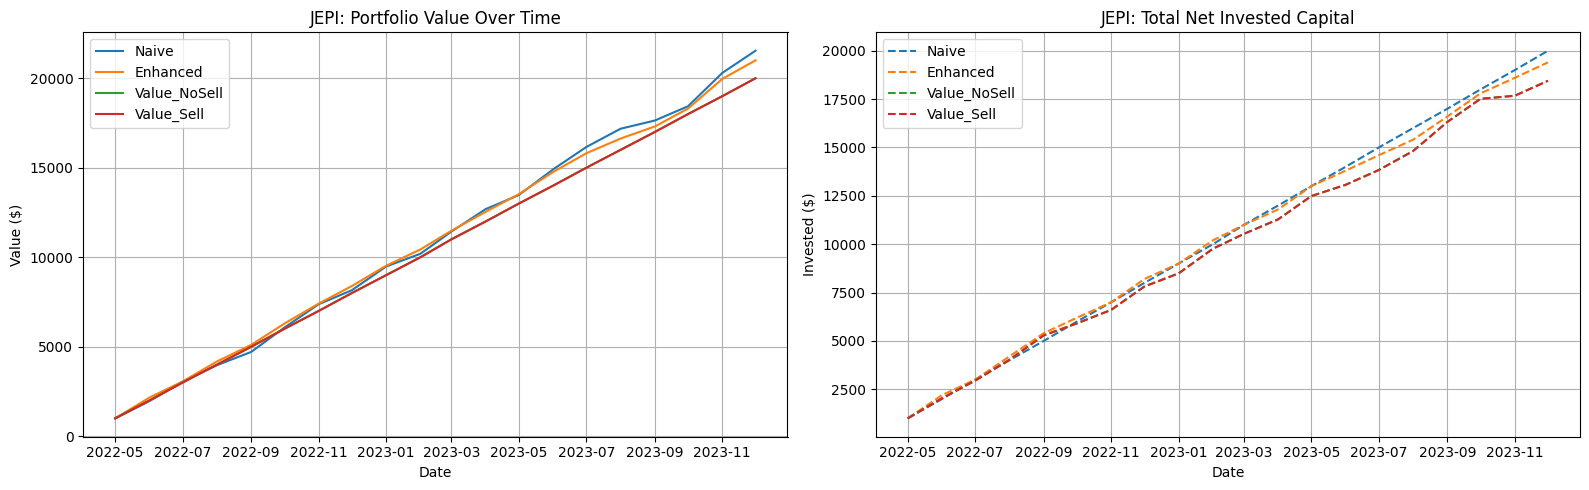

In [27]:
summary_metrics = []

for ticker in tickers:
    if ticker not in data.columns:
        print(f"Skipping {ticker} - no data")
        continue
        
    res = run_strategies(data[ticker], base_investment, delta, target_growth)
    
    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    dates = data.index
    
    # Portfolio Value
    for strategy, metrics in res.items():
        ax[0].plot(dates, metrics['portfolio_value'], label=strategy)
    
    ax[0].set_title(f'{ticker}: Portfolio Value Over Time')
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Value ($)')
    ax[0].legend()
    ax[0].grid(True)

    # Total Invested Capital
    for strategy, metrics in res.items():
        ax[1].plot(dates, metrics['invested'], label=strategy, linestyle='--')
    
    ax[1].set_title(f'{ticker}: Total Net Invested Capital')
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Invested ($)')
    ax[1].legend()
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate Summary Metrics
    for strategy, metrics in res.items():
        final_value = metrics['portfolio_value'][-1]
        total_invested = metrics['invested'][-1]
        profit = final_value - total_invested
        # Simple ROI for comparison
        roi = (profit / total_invested) * 100 if total_invested != 0 else 0
        
        summary_metrics.append({
            'Ticker': ticker,
            'Type': 'High Beta' if ticker in high_beta_tickers else 'Low Beta',
            'Strategy': strategy,
            'Total Invested': total_invested,
            'Final Value': final_value,
            'Profit': profit,
            'ROI (%)': roi
        })


In [28]:
# Summary Table
df_summary = pd.DataFrame(summary_metrics)
df_summary.sort_values(by=['Ticker', 'ROI (%)'], ascending=[True, False])


,Ticker,Type,Strategy,Total Invested,Final Value,Profit,ROI (%)
18,JEPI,Low Beta,Value_NoSell,18447.564991,20000.000000,1552.435009,8.415393
19,JEPI,Low Beta,Value_Sell,18447.564991,20000.000000,1552.435009,8.415393
17,JEPI,Low Beta,Enhanced,19400.000000,21002.347554,1602.347554,8.259523
16,JEPI,Low Beta,Naive,20000.000000,21539.471249,1539.471249,7.697356
14,JEPQ,Low Beta,Value_NoSell,16370.465097,20000.000000,3629.534903,22.171239
15,JEPQ,Low Beta,Value_Sell,16379.195716,20000.000000,3620.804284,22.106118
13,JEPQ,Low Beta,Enhanced,19400.000000,23263.736579,3863.736579,19.916168
12,JEPQ,Low Beta,Naive,20000.000000,23834.066646,3834.066646,19.170333
7,QQQ,High Beta,Value_Sell,14794.709278,20000.000000,5205.290722,35.183461
6,QQQ,High Beta,Value_NoSell,15753.101244,21008.803164,5255.701919,33.362967


In [29]:
# Average ROI by Strategy and Asset Type
pivot_roi = df_summary.pivot_table(values='ROI (%)', index='Strategy', columns='Type', aggfunc='mean')
pivot_roi


Type,High Beta,Low Beta
Strategy,,
Enhanced,42.948324,14.087846
Naive,41.154560,13.433845
Value_NoSell,58.318600,15.293316
Value_Sell,98.054509,15.260755


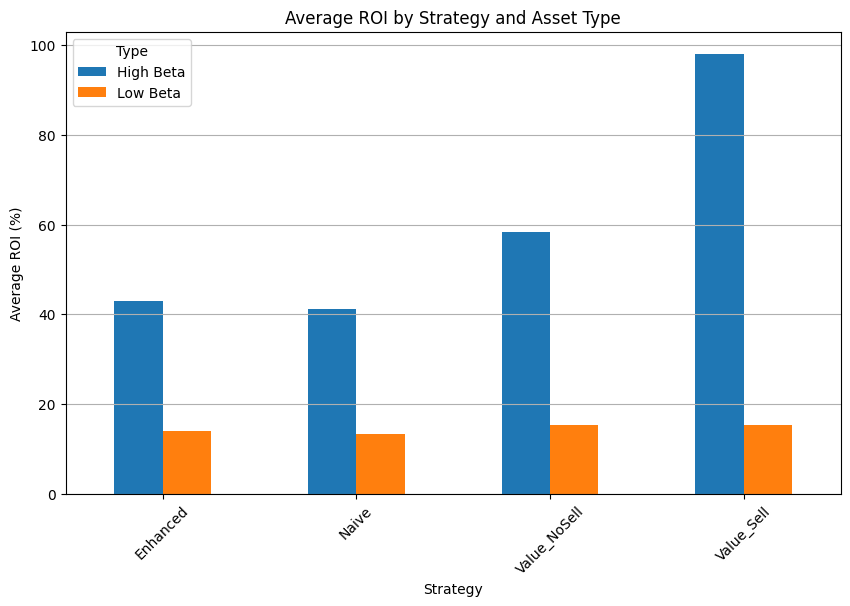

In [30]:
pivot_roi.plot(kind='bar', figsize=(10, 6))
plt.title('Average ROI by Strategy and Asset Type')
plt.ylabel('Average ROI (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()
